In [1]:
import torch
import pickle
import os,sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../../")

from human_aware_rl.rllib.rllib import reset_dummy_policy, gen_trainer_from_params
from human_aware_rl.rllib.utils import get_base_ae
from human_aware_rl.dummy.rl_agent import *
from overcooked_ai_py.agents.agent import AgentPair

In [2]:
def load_checkpoint(file_path):
    assert os.path.isfile(file_path)
    with open(file_path, 'rb') as file:
        checkpoint = pickle.load(file)
    return checkpoint


def run_rl_training(params):
    # Retrieve the tune.Trainable object that is used for the experiment
    trainer = gen_trainer_from_params(params)
    # Object to store training results in
    result = {}

    # Training loop
    for i in range(params['num_training_iters']):
        result = trainer.train()

        msg = result['episode_reward_mean']
        msg2 = result['episode_reward_max']
        msg3 = result['episode_reward_min']
        if i % 10 == 0:
            print(f'{i}: ep rew mean={msg}, max={msg2}, min={msg3}')
        trainer.workers.foreach_worker(lambda ev: reset_dummy_policy(ev.get_policy('dummy')))
    
    return result

def getVisitation(states, joint_action, env):
    target_player_idx = 0
    num_game = len(states)
    freq = {}
    for game, actions in zip(states,joint_action):
        for s,a in zip(game,actions):
            reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
            reward_features = tuple(reward_features)
            if reward_features not in freq:
                freq[reward_features] = 0
            freq[reward_features] += 1
    
    for state in freq:
        freq[state] /= num_game
    return freq

def getExpertVisitation(train_config, agent):
    mdp_params = train_config["environment_params"]["mdp_params"]
    env_params = train_config["environment_params"]["env_params"]
    ae = get_base_ae(mdp_params, env_params)
    env = ae.env

    states = []
    actions = []
    # agents = [MAICooperativeAgent()]
    agents = [agent]

    for a in agents:
        agent_pair = AgentPair(a, MAIDummyRightCoopAgent())
        results = env.get_rollouts(agent_pair=agent_pair, num_games=1, display=True)
        states.append(results['ep_states'])
        actions.append(results['ep_actions'])

    act = []
    for traj in actions:
        temp = []
        for idx in traj[0]:
            temp.append([Action.ACTION_TO_INDEX[idx[0]], Action.ACTION_TO_INDEX[idx[1]]])
        act.append(temp)
    actions = act
    states = np.concatenate(states, axis=0)
    
    target_player_idx = 0
    features = []    
    for game, act in zip(states,actions):
        for s,a in zip(game,act):
            reward_features = env.human_coop_state_encoding(s, a, 0)[target_player_idx]
            features.append(reward_features)
    return features

def getAgentVisitation(train_config, env): #get the feature expectations of a new policy using RL agent
    '''
    Trains an RL agent with the current reward function. 
    Then rolls out one trial of the trained agent and calculate the feature expectation of the RL agent.
    - train_config: the configuration taken by the rllib trainer
    
    Returns the feature expectation.
    '''
    # train and get rollouts
    try:
        results = run_rl_training(train_config)
        states = results['evaluation']['states']
        actions = results['evaluation']['actions']
        scores = results['evaluation']['sparse_reward']
        actions = _convertAction2Index(actions)
        state_visit = getVisitation(states, actions, env)
        return state_visit
    except Exception as e:
        print('ERROR: could not get Agent Visitation. --> ' + str(e))

In [7]:
coop_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T22_coop/epoch=100.checkpoint"

print(f'loading model checkpoint from {coop_ckpt}...')
coop_ckpt = load_checkpoint(coop_ckpt)

print(f'retrieving reward model and optimizer...')
coop_reward_model = coop_ckpt["reward_model"]

print(f'loading configurations...')
coop_config = coop_ckpt['config']

print(f'getting expert trajectory and state visitation...')
coop_state_visit = coop_ckpt['expert_svf']
print(f'complete')

loading model checkpoint from /home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T22_coop/epoch=100.checkpoint...
retrieving reward model and optimizer...
loading configurations...
getting expert trajectory and state visitation...
complete


In [8]:
noncoop_ckpt = "/home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T22_noncoop/epoch=100.checkpoint"

print(f'loading model checkpoint from {noncoop_ckpt}...')
noncoop_ckpt = load_checkpoint(noncoop_ckpt)

print(f'retrieving reward model and optimizer...')
noncoop_reward_model = noncoop_ckpt["reward_model"]

print(f'loading configurations...')
noncoop_config = noncoop_ckpt['config']

print(f'getting expert trajectory and state visitation...')
noncoop_state_visit = noncoop_ckpt['expert_svf']
print(f'complete')

loading model checkpoint from /home/jasmine/moral-ai-irl/human_aware_rl_master/human_aware_rl/irl/result/human/T22_noncoop/epoch=100.checkpoint...
retrieving reward model and optimizer...
loading configurations...
getting expert trajectory and state visitation...
complete


In [5]:
COOP_BOT_SVF = getExpertVisitation(coop_config, MAICooperativeAgent())
NONCOOP_BOT_SVF = getExpertVisitation(noncoop_config, MAINonCoopAgent())

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 5.00; : 100%|██████████| 1/1 [00:00<00:00, 141.55it/s]


Timestep: 1
Joint action taken: ('↓', '←') 	 Reward: 0 + shaping_factor * [0, 0]
Action probs by index: [None, None]  
X       X       X       P       X       X       X       X       P       X       X       X       

X                                       S       X       ←1                              X       

D               X       X               X       X               X       X               S       

X                               ↓0o     X                                               X       

X       X       X       X       O       X       X               X       X       D       X       

X       X       X       X       X       X       X               X       X       X       X       

X       X       X       X       X       X       X                               O       X       

X       X       X       X       X       X       X       X       X       X       X       X       



Timestep: 2
Joint action taken: ('interact', '↓') 	 Reward: 0 + shaping_factor * [0, 0]
Action 

Avg rew: 0.00 (std: 0.00, se: 0.00); avg len: 8.00; : 100%|██████████| 1/1 [00:00<00:00, 94.28it/s]

Timestep: 1
Joint action taken: ('↓', '←') 	 Reward: 0 + shaping_factor * [0, 0]
Action probs by index: [None, None]  
X       X       X       P       X       X       X       X       P       X       X       X       

X                                       S       X       ←1                              X       

D               X       X               X       X               X       X               S       

X                               ↓0o     X                                               X       

X       X       X       X       O       X       X               X       X       D       X       

X       X       X       X       X       X       X               X       X       X       X       

X       X       X       X       X       X       X                               O       X       

X       X       X       X       X       X       X       X       X       X       X       X       



Timestep: 2
Joint action taken: ('interact', '↓') 	 Reward: 0 + shaping_factor * [0, 0]
Action 

In [9]:
LEN_BOT_COOP_TRAJ = len(COOP_BOT_SVF) # states are distinct in pre-programmed bots
LEN_BOT_NONCOOP_TRAJ = len(NONCOOP_BOT_SVF) # states are distinct in pre-programmed bots
LEN_HUMAN_COOP_TRAJ = 6.9489
LEN_HUMAN_NONCOOP_TRAJ = 13.5395
def get_stats(reward_model, states, avg_len):
    lst = []
    hidden = None
    for state in states:
        reward, hidden = reward_model.get_rewards(state, hidden)
        lst.append(reward[0].item())
    lst = torch.tensor(lst)
    lst = torch.nn.functional.normalize(lst, dim=0)
    # print(lst)
    avg = sum(lst) / avg_len
    return avg
    
print(f'For a reward function derived from cooperative human expert:')
print(f'\tfor cooperative behavior: avg reward per step={get_stats(coop_reward_model, COOP_BOT_SVF, LEN_BOT_COOP_TRAJ)}')
print(f'\tfor non-cooperative behavior: avg reward per step={get_stats(coop_reward_model, NONCOOP_BOT_SVF, LEN_BOT_NONCOOP_TRAJ)}')

print(f'For a reward function derived from non-cooperative human expert:')
print(f'\tfor cooperative behavior: avg reward per step={get_stats(noncoop_reward_model, COOP_BOT_SVF, LEN_BOT_COOP_TRAJ)}')
print(f'\tfor non-cooperative behavior: avg reward per step={get_stats(noncoop_reward_model, NONCOOP_BOT_SVF, LEN_BOT_NONCOOP_TRAJ)}')


For a reward function derived from cooperative human expert:
	for cooperative behavior: avg reward per step=-0.4471755623817444
	for non-cooperative behavior: avg reward per step=-0.35084301233291626
For a reward function derived from non-cooperative human expert:
	for cooperative behavior: avg reward per step=-0.4472057819366455
	for non-cooperative behavior: avg reward per step=-0.21032673120498657


In [18]:
feat = torch.diag(torch.ones(18))

noncoop_reward_per_feat = noncoop_reward_model.get_rewards(feat).squeeze()
coop_reward_per_feat = coop_reward_model.get_rewards(feat).squeeze()
noncoop_reward_per_feat = torch.nn.functional.normalize(noncoop_reward_per_feat, dim=0)
coop_reward_per_feat = torch.nn.functional.normalize(coop_reward_per_feat, dim=0)
print(coop_reward_per_feat)
print(noncoop_reward_per_feat)


tensor([-0.1109,  0.0703,  0.0010, -0.0448, -0.2371, -0.4021, -0.1956, -0.1183,
        -0.1801, -0.1507, -0.1290, -0.1399, -0.0625,  0.7423, -0.1316, -0.1256,
        -0.1194, -0.1302])
tensor([ 0.0096, -0.0553, -0.0082, -0.0620,  0.0271, -0.0401, -0.0394,  0.2155,
        -0.0752,  0.0024,  0.0195,  0.0192,  0.1679,  0.9522,  0.0187,  0.0182,
         0.0197,  0.0184])


In [37]:
import matplotlib.pyplot as plt

FEATURES_1 = [
    'p0_x', 'p0_y', 'p1_x', 'p1_y', 
    'p0_ori(N)', 'p0_ori(S)', 'p0_ori(E)', 'p0_ori(W)', 
    'p1_ori(N)', 'p1_ori(S)', 'p1_ori(E)', 'p1_ori(W)', 
    'p0_withOnion', 'p1_wOnion', 
    'onion_on_bridge', 
    'onion_in_pot',
    'urgent',
    'sth'
    ]

FEATURES_2 = [
    'p0 onion dx', 'p0 onion dy', 
    'p0 bridge dx', 'p0 bridge dy', 
    'p0 stove dx', 'p0 stove dy', 
    'p0 orientation(N)', 'p0 orientation(S)', 'p0 orientation(E)', 'p0 orientation(W)',  
    'p0 withOnion', 
    'p1 withOnion',
    'onion on bridge',
    'No. of onion in pot',
    'p0 at (4,3) w/ onion',
    'p0 at (4,2) w/ onion',
    'p0 at (4,1) w/ onion',
    'p0 at (3,1) w/ onion',
    ]

FEATURES_3 = [
    'onion_on_bridge', 
    'onion_in_pot'
]

FEATURES = FEATURES_2

import numpy as np 

def plot_bar(rewards1, rewards2, title):
    bar_labels_1 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards1]
    bar_labels_2 = ["{:.2f}".format(round(r.item(), 2)) for r in rewards2]
    plt.clf()

    plt.figure() 

    n = len(FEATURES)
    r = np.arange(n)
    height = 0.5

    bar_1 = plt.barh(r, rewards1, label="cooperative")
    bar_2 = plt.barh(r + height, rewards2, label="non-cooperative")
    plt.xlim([-1.0, 1.0])
    plt.bar_label(bar_1, bar_labels_1)
    plt.bar_label(bar_2, bar_labels_2)
    plt.yticks(r + height / 2, FEATURES)
    plt.legend()
    plt.title(title)
    plt.plot()
    plt.savefig('t20_human_reward_comparison.pdf', format='pdf', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

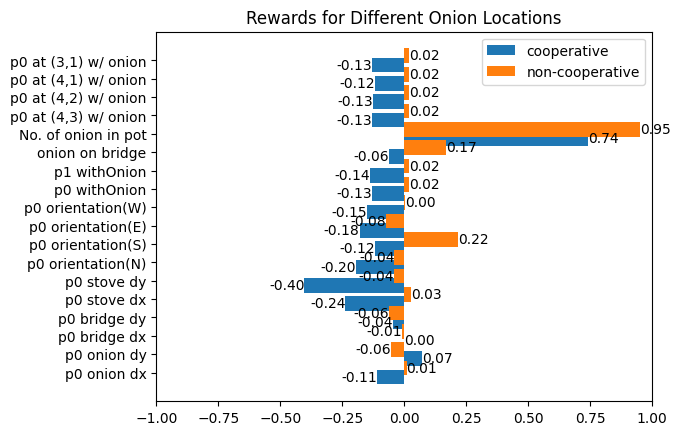

In [38]:
plot_bar(coop_reward_per_feat[:], noncoop_reward_per_feat[:], 'Rewards for Different Onion Locations')